In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error
from scipy import stats
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
all_data = pd.read_csv(r'final_features.csv')

In [4]:
# Load additional features
glove_tags = pd.read_csv(r'alltags_feature.csv')
glove_title = pd.read_csv(r'title_feature.csv')
all_data = pd.concat([all_data, glove_tags, glove_title], axis=1)

0     55069
6     47822
4     39090
5     23319
9     18897
8     16684
1     16414
7     14032
2     12366
3      4059
10     3543
Name: Category, dtype: int64

In [6]:
# Split the data
train_all_data, submit_all_data = train_test_split(all_data, stratify=all_data['Category'], test_size=0.2, random_state=42)

# Reset index
train_all_data = train_all_data.reset_index(drop=True)
submit_all_data = submit_all_data.reset_index(drop=True)

# Define feature columns
feature_columns = ['Pid', 'label', 'mean_label'] 
feature_columns += ['user_fe_{}'.format(i) for i in range(399)]
feature_columns += ['loc_fe_{}'.format(i) for i in range(400)]

# Prepare labels and features
train_label_df = train_all_data[['Pid', 'label']]
train_feature_df = train_all_data.drop(feature_columns, axis=1)

submit_label_df = submit_all_data[['Pid', 'label']]
submit_feature_df = submit_all_data.drop(feature_columns, axis=1)

In [7]:
# Label encode categorical columns
cate_cols = ['Category', 'Subcategory', 'Concept', 'hour', 'day', 'weekday', 'week_hour', 'year_weekday',
             'Geoaccuracy', 'ispro', 'img_model']

In [9]:
# LightGBM parameters
lgb_params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.03,
    'num_leaves': 64,
    'max_depth': 8,
    'verbose': 1,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
}

valid_ans = []
submit_proba = []
kfold = KFold(n_splits=5, shuffle=True, random_state=2020)
best_mae = float('inf')
best_model = None
model_save_path = r'/Users/bhavana/Documents/MSDA/Fall2023/DATA255/project/saved_models'

for n, (train_idx, valid_idx) in enumerate(kfold.split(train_feature_df, train_label_df)):
    fold_train_x, fold_train_y = train_feature_df.loc[train_idx], train_label_df['label'].loc[train_idx]
    fold_valid_x, fold_valid_y = train_feature_df.loc[valid_idx], train_label_df['label'].loc[valid_idx]
    
    lgb_train = lgb.Dataset(fold_train_x, fold_train_y, categorical_feature=cate_cols)
    lgb_valid = lgb.Dataset(fold_valid_x, fold_valid_y, categorical_feature=cate_cols)
    
    print('Training start')
    
    lgb_model = lgb.train(lgb_params, lgb_train, valid_sets=[lgb_valid])
    
    print('Training end')
    
    valid_pred = lgb_model.predict(fold_valid_x)
    valid_rmse = np.sqrt(mean_squared_error(fold_valid_y, valid_pred))
    valid_mae = mean_absolute_error(fold_valid_y, valid_pred)
    valid_src = stats.spearmanr(fold_valid_y, valid_pred)[0]
    
    print(f"Fold {n}: RMSE: {valid_rmse:.4f}, MAE: {valid_mae:.4f}, SRC: {valid_src:.4f}")
    
    # Check if this model is the best so far
    if valid_mae < best_mae:
        best_mae = valid_mae
        best_model = lgb_model
        best_actuals = fold_valid_y
        best_predictions = valid_pred
        # Save the best model
        best_model.save_model(os.path.join(model_save_path, 'best_model.pkl'))

    valid_ans.append([valid_rmse, valid_mae, valid_src])
        
    submit_pred = lgb_model.predict(submit_feature_df)
    submit_proba.append(submit_pred)

# Calculate mean of the validation answers
valid_ans = np.mean(valid_ans, axis=0)
print(f"Valid: RMSE: {valid_ans[0]:.4f}, MAE: {valid_ans[1]:.4f}, SRC: {valid_ans[2]:.4f}")
print('\n')

# Evaluate performance on test data
submit_actuals = submit_label_df['label']
submit_predictions = best_model.predict(submit_feature_df)
test_rmse = np.sqrt(mean_squared_error(submit_actuals, submit_predictions))
test_mae = mean_absolute_error(submit_actuals, submit_predictions)
test_src = stats.spearmanr(submit_actuals, submit_predictions)[0]

# Print test metrics
print(f"Test results: RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, SRC: {test_src:.4f}")


# Save result to csv
submit_ans = np.mean(submit_proba, axis=0)
result = pd.DataFrame()
result['post_id'] = submit_label_df['Pid'].apply(lambda x: f'post{x}')
result['popularity_score'] = submit_ans.round(decimals=4)

# Save the CSV output, modify the path as needed
result.to_csv(r'/Users/bhavana/Documents/MSDA/Fall2023/DATA255/project/KFold_lightgbm_results.csv', index=False)

Training start
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.631803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 167280
[LightGBM] [Info] Number of data points in the train set: 160828, number of used features: 665
[LightGBM] [Info] Start training from score 6.359941
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.623861
Training end
Fold 0: RMSE: 1.0426, MAE: 0.6239, SRC: 0.9118
Training start
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignore

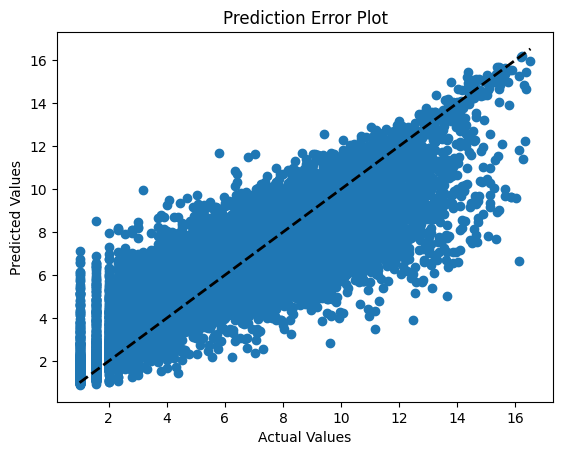

In [10]:
plt.scatter(best_actuals, best_predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction Error Plot")
plt.plot([best_actuals.min(), best_actuals.max()], [best_actuals.min(), best_actuals.max()], 'k--', lw=2)
plt.show()

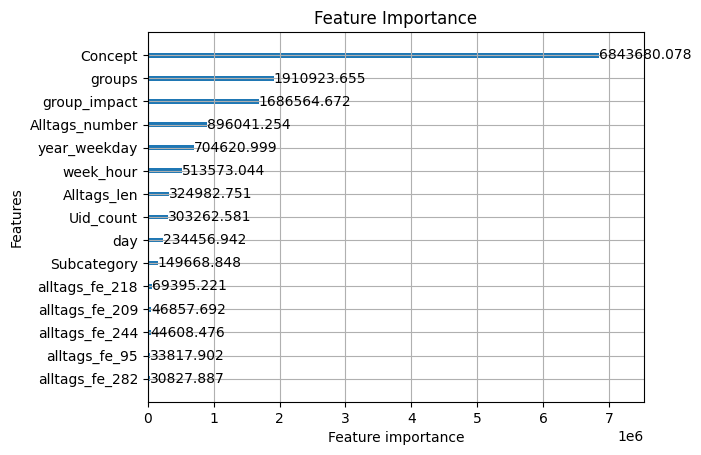

In [27]:
import matplotlib.pyplot as plt

# Feature Importance Plot for the best model
lgb.plot_importance(best_model, max_num_features=15, importance_type='gain')
plt.title("Feature Importance")
plt.show()

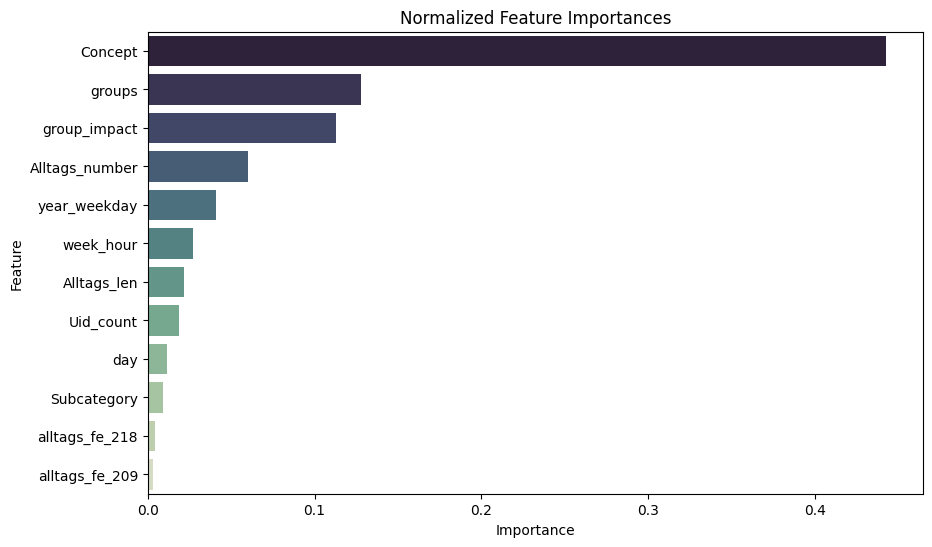

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pandas as pd

# Extract feature importances and normalize them
feature_importances = best_model.feature_importance(importance_type='gain')
normalized_feature_importances = feature_importances / feature_importances.sum()

# Create a DataFrame for easy plotting
features = best_model.feature_name()
df_feature_importances = pd.DataFrame({'Feature': features, 'Importance': normalized_feature_importances})

# Sort the DataFrame by importance
df_feature_importances = df_feature_importances.sort_values('Importance', ascending=False).head(12)

# Plot using a color palette that reflects importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_feature_importances, 
            palette=sns.cubehelix_palette(n_colors=12, start=.5, rot=-.75, reverse=True))
plt.title('Normalized Feature Importances')
plt.show()

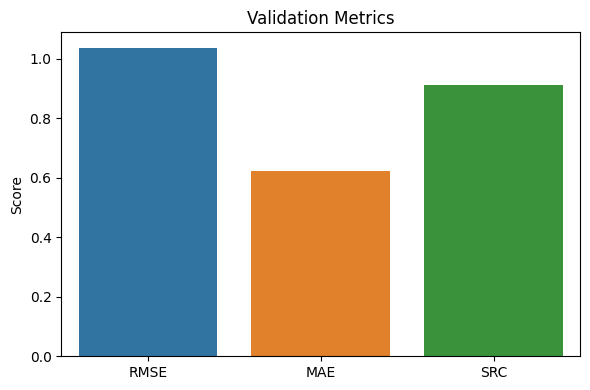

In [13]:
# Assuming valid_ans is a 1x3 array with metrics in the order: RMSE, MAE, SRC
validation_metrics = np.array(valid_ans)  # Convert valid_ans to a numpy array

metrics = ['RMSE', 'MAE', 'SRC']
plt.figure(figsize=(6, 4))

# Plotting the metrics
sns.barplot(x=metrics, y=validation_metrics)
plt.title('Validation Metrics')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

In [14]:
#10000 iterations

In [16]:
# LightGBM parameters
lgb_params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.03,
    'num_leaves': 64,
    'max_depth': 8,
    'verbose': 1,
    'n_estimators': 10000,
    'early_stopping_rounds': 50,
}

valid_ans = []
submit_proba = []
kfold = KFold(n_splits=5, shuffle=True, random_state=2020)
best_mae = float('inf')
best_model = None
model_save_path = r'/Users/bhavana/Documents/MSDA/Fall2023/DATA255/project/saved_models'

for n, (train_idx, valid_idx) in enumerate(kfold.split(train_feature_df, train_label_df)):
    fold_train_x, fold_train_y = train_feature_df.loc[train_idx], train_label_df['label'].loc[train_idx]
    fold_valid_x, fold_valid_y = train_feature_df.loc[valid_idx], train_label_df['label'].loc[valid_idx]
    
    lgb_train = lgb.Dataset(fold_train_x, fold_train_y, categorical_feature=cate_cols)
    lgb_valid = lgb.Dataset(fold_valid_x, fold_valid_y, categorical_feature=cate_cols)
    
    print('Training start')
    
    lgb_model = lgb.train(lgb_params, lgb_train, valid_sets=[lgb_valid])
    
    print('Training end')
    
    valid_pred = lgb_model.predict(fold_valid_x)
    valid_rmse = np.sqrt(mean_squared_error(fold_valid_y, valid_pred))
    valid_mae = mean_absolute_error(fold_valid_y, valid_pred)
    valid_src = stats.spearmanr(fold_valid_y, valid_pred)[0]
    
    print(f"Fold {n}: RMSE: {valid_rmse:.4f}, MAE: {valid_mae:.4f}, SRC: {valid_src:.4f}")
    
    # Check if this model is the best so far
    if valid_mae < best_mae:
        best_mae = valid_mae
        best_model = lgb_model
        best_actuals = fold_valid_y
        best_predictions = valid_pred
        # Save the best model
        best_model.save_model(os.path.join(model_save_path, 'best_model_10000.pkl'))

    valid_ans.append([valid_rmse, valid_mae, valid_src])
        
    submit_pred = lgb_model.predict(submit_feature_df)
    submit_proba.append(submit_pred)

# Calculate mean of the validation answers
valid_ans = np.mean(valid_ans, axis=0)
print(f"Valid: RMSE: {valid_ans[0]:.4f}, MAE: {valid_ans[1]:.4f}, SRC: {valid_ans[2]:.4f}")
print('\n')

# Evaluate performance on test data
submit_actuals = submit_label_df['label']
submit_predictions = best_model.predict(submit_feature_df)
test_rmse = np.sqrt(mean_squared_error(submit_actuals, submit_predictions))
test_mae = mean_absolute_error(submit_actuals, submit_predictions)
test_src = stats.spearmanr(submit_actuals, submit_predictions)[0]

# Print test metrics
print(f"Test results: RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, SRC: {test_src:.4f}")


# Save result to csv
submit_ans = np.mean(submit_proba, axis=0)
result = pd.DataFrame()
result['post_id'] = submit_label_df['Pid'].apply(lambda x: f'post{x}')
result['popularity_score'] = submit_ans.round(decimals=4)

# Save the CSV output, modify the path as needed
result.to_csv(r'/Users/bhavana/Documents/MSDA/Fall2023/DATA255/project/KFold_lightgbm_results_10000.csv', index=False)

Training start
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.615972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 167280
[LightGBM] [Info] Number of data points in the train set: 160828, number of used features: 665
[LightGBM] [Info] Start training from score 6.359941
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9862]	valid

Test results: RMSE: 0.9826, MAE: 0.5451, SRC: 0.9259


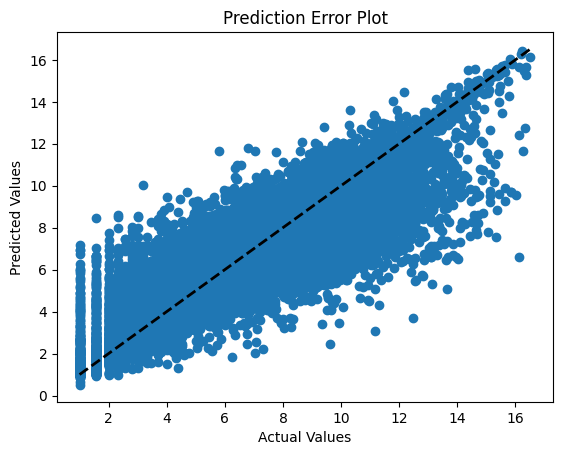

In [17]:
plt.scatter(best_actuals, best_predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction Error Plot")
plt.plot([best_actuals.min(), best_actuals.max()], [best_actuals.min(), best_actuals.max()], 'k--', lw=2)
plt.show()

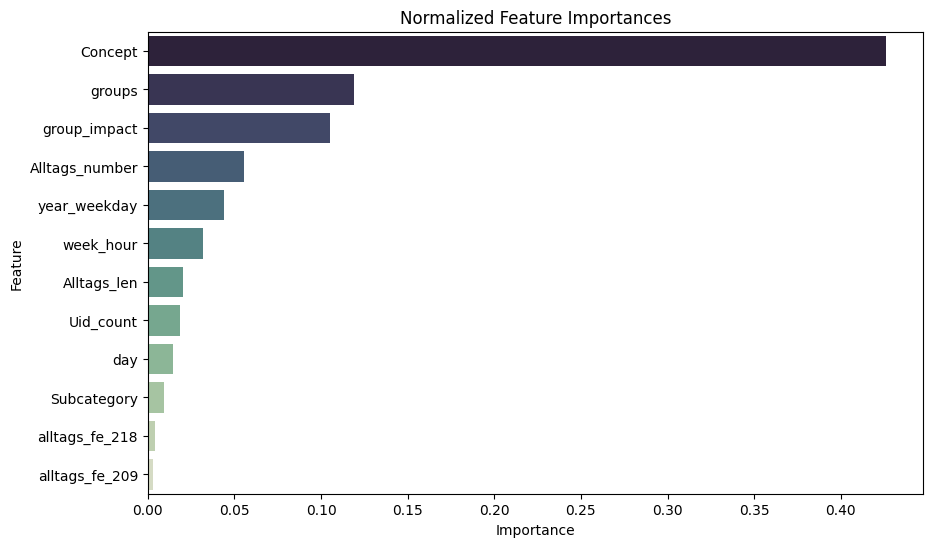

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pandas as pd

# Extract feature importances and normalize them
feature_importances = best_model.feature_importance(importance_type='gain')
normalized_feature_importances = feature_importances / feature_importances.sum()

# Create a DataFrame for easy plotting
features = best_model.feature_name()
df_feature_importances = pd.DataFrame({'Feature': features, 'Importance': normalized_feature_importances})

# Sort the DataFrame by importance
df_feature_importances = df_feature_importances.sort_values('Importance', ascending=False).head(12)

# Plot using a color palette that reflects importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_feature_importances, 
            palette=sns.cubehelix_palette(n_colors=12, start=.5, rot=-.75, reverse=True))
plt.title('Normalized Feature Importances')
plt.show()

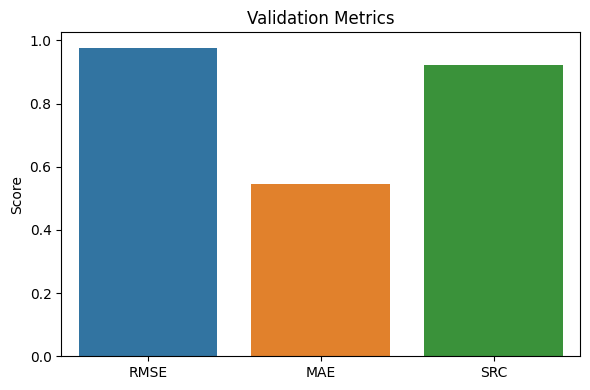

In [19]:
# Assuming valid_ans is a 1x3 array with metrics in the order: RMSE, MAE, SRC
validation_metrics = np.array(valid_ans)  # Convert valid_ans to a numpy array

metrics = ['RMSE', 'MAE', 'SRC']
plt.figure(figsize=(6, 4))

# Plotting the metrics
sns.barplot(x=metrics, y=validation_metrics)
plt.title('Validation Metrics')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

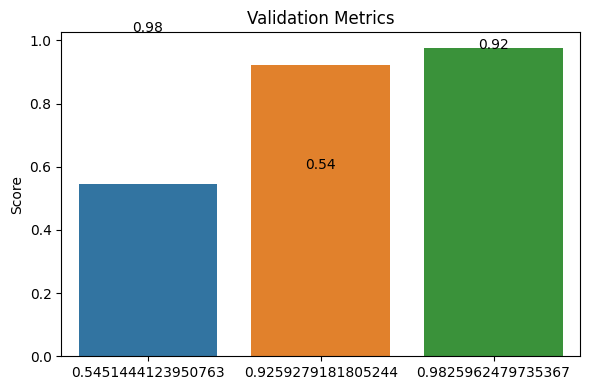

In [25]:
validation_metrics = np.array(valid_ans)  # Convert valid_ans to a numpy array
labels = ['RMSE', 'MAE', 'SRC']

# Plotting the metrics
plt.figure(figsize=(6, 4))
sns.barplot(x=metrics, y=validation_metrics)
plt.title('Validation Metrics')
plt.ylabel('Score')

# Adding exact values on top of the bars
for i, v in enumerate(validation_metrics):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

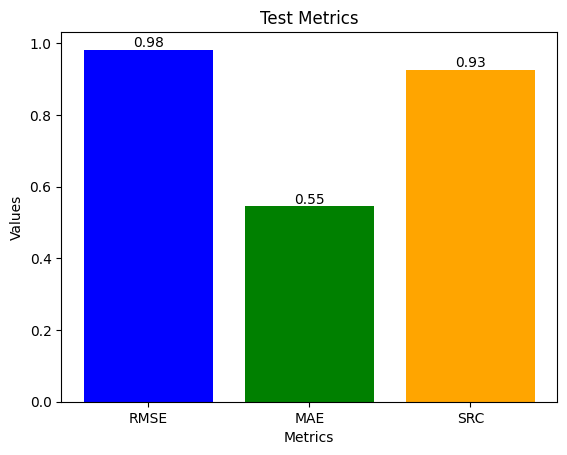

In [24]:
metrics = [test_rmse, test_mae, test_src]
labels = ['RMSE', 'MAE', 'SRC']

# Create a bar plot
plt.bar(labels, metrics, color=['blue', 'green', 'orange'])

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Test Metrics')

# Display the values on top of the bars
for i, value in enumerate(metrics):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()